In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as data

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Usual Preamble - note that I'm creating a deliberately small training set out of the main training data here. Hoping to illustrate some overfitting-avoidance.

In [50]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

print(f"Training set shape: {trainset.data.shape}")
print(f"Testing set shape: {testset.data.shape}")

def preprocess_data(dataset):
    data = (dataset.data / 255.0) - 0.5
    targets = dataset.targets
    return data, targets

x_train, y_train = preprocess_data(trainset)
x_test, y_test = preprocess_data(testset)

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_train_small = x_train[ 0 : 10000 ]
y_train_small = y_train[ 0 : 10000 ]

train_dataset = data.TensorDataset(x_train_small, y_train_small)

batch_size = 64
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Training set shape: torch.Size([60000, 28, 28])
Testing set shape: torch.Size([10000, 28, 28])


### Architecture

In [51]:
class MNISTNetwork_FF(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = torch.nn.Linear( in_features = 784, out_features = 1000 )
    self.layer_2 = torch.nn.Linear( in_features = 1000, out_features = 10 )

  def forward(self, x):
    flattened = nn.Flatten()( x )

    hidden_nodes = self.layer_1( flattened )
    hidden_nodes = torch.nn.Tanh()( hidden_nodes )

    logits = self.layer_2( hidden_nodes )
    return logits

class MNISTNetwork_CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_1 = torch.nn.Conv2d( in_channels = 1, out_channels = 20, kernel_size = (3,3), stride = 1 )

    #### I should be going over this in class today, but make sure that they feel comfortable with what this is setting up
    #### The idea of 1 value coming in at each location (grayscale), computing 20 features with each kernel window
    #### And applying the 3x3 kernel window at a stride of 1

    #### Worth being clear here: there are 26 x 26 possible locations we can apply this kernel window
    #### So 26*26 sets of 9 pixels we are computing these features on :::
    #### Each kernel should contain 9 weights in a 3x3 matrix, and a constant bias parameter
    #### Leading to 26 * 26 * 20 output features, arranged in a [20, 26, 26] feature stack

    ### And there should be 20 * 10 = 200 total weights in this layer.

    ### Note, I've added a 'Verbose' option to the forward pass if you want to print out some description,
    ### not necessary though


    self.linear = torch.nn.Linear( in_features = 26*26*20, out_features = 10 )

    ### We are then going to take the [ 20 x 26 x 26 ] block, flatten it, and pass it into the final layer to get 10 logits

  def forward(self, x, verbose = False):

    if verbose:
      print("Input Dimension:", x.shape)

    reshaped = torch.reshape( x, (-1, 1, 28, 28) )
    #### Note, this is formatting the initial [N x 28 x 28] input as [N x 1 x 28 x 28],
    #### specifying that the input has a single value at each of the 28x28 locations
    #### This is important
    #### but I'm just writing what I think might be worth saying) because you may have inputs with more than 1 value
    #### Like RGB images, which would be [ 3 x height x width ]
    #### Don't remember why the default behavior is with the dimensions ordered in this way,
    #### but I assume it makes something nicer about the matrix multiplication under the hood

    if verbose:
      print("Reshaped for CNN use:", reshaped.shape)

    conv_results = self.conv_1( reshaped ) ## We can apply a convolutional layer exactly as we have previous layers

    if verbose:
      print("After applying the CNN layer:", conv_results.shape )

    conv_results = torch.nn.Tanh()( conv_results ) ## Apply the activation function

    flattened = torch.nn.Flatten()( conv_results ) ## Flatten the results to a single linear vector, which we can then pass into a normal linear transformation

    if verbose:
      print("Flattened shape:", flattened.shape)

    logits = self.linear( flattened ) ## Compute the logits

    if verbose:
      print("Final Output:", logits.shape)

    return logits

In [52]:
model_ff = MNISTNetwork_FF().to(device)
model_cnn = MNISTNetwork_CNN().to(device)

ff_params = sum(p.numel() for p in model_ff.parameters() if p.requires_grad)
cnn_params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Feed-Forward network total parameters: {ff_params}")
print(f"Simple CNN total parameters: {cnn_params}")

Feed-Forward network total parameters: 795010
Simple CNN total parameters: 135410


In [53]:
logits_train_small = model_cnn( x_train_small, verbose = True)

Input Dimension: torch.Size([10000, 28, 28])
Reshaped for CNN use: torch.Size([10000, 1, 28, 28])
After applying the CNN layer: torch.Size([10000, 20, 26, 26])
Flattened shape: torch.Size([10000, 13520])
Final Output: torch.Size([10000, 10])


In [54]:
model_cnn.conv_1.weight.shape

torch.Size([20, 1, 3, 3])

In [55]:
model_cnn.conv_1.bias.shape

torch.Size([20])

In [56]:
#@title Visualize a single forward pass for the Logistic Reg
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def _to_numpy(t):
  return t.detach().cpu().numpy()

def _imshow(ax, img, title="", cmap="gray", hide_ticks=True, vmin=None, vmax=None):
  ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
  if title: ax.set_title(title, fontsize=10)
  if hide_ticks:
    ax.set_xticks([]); ax.set_yticks([])

@torch.no_grad()
def visualize_forward_pass_ff(model, x, class_names=None, device="cpu"):
  """
  Show:
    1) Original input image
    2) Top-5 activated contributors (activation * W2[pred])
    3) Final logits / softmax probabilities
  """
  model = model.to(device).eval()

  # normalize input shape
  if x.ndim == 2:
    x = x.unsqueeze(0)
  if x.ndim == 3 and x.shape[0] != 1:
    x = x[:1]
  x = x.to(device)

  # forward with intermediates
  flat = torch.flatten(x, 1)                      # [1,784]
  z1 = model.layer_1(flat)                        # [1,1000]
  h  = torch.tanh(z1)                             # activations
  logits = model.layer_2(h)
  probs  = torch.softmax(logits, dim=-1)
  pred   = int(torch.argmax(probs, dim=-1).item())

  # contribution scores for hidden units
  w2_pred = model.layer_2.weight[pred]            # [1000]
  contrib = (h[0] * w2_pred).detach().cpu().numpy()
  top_idx = np.argsort(-np.abs(contrib))[:5]      # top-5 |contribution|
  W1 = model.layer_1.weight.detach().cpu().numpy()

  # plotting
  fig, axs = plt.subplots(2, 5, figsize=(14, 6))
  axs = axs.ravel()

  # 1) original input
  axs[0].imshow(x[0].cpu(), cmap="gray")
  axs[0].set_title("Input")
  axs[0].axis("off")

  # 2) top-5 contributor maps
  for i in range(5):
    w_map = W1[top_idx[i]].reshape(28, 28)
    vmax = np.abs(w_map).max() + 1e-8
    axs[i+1].imshow(w_map, cmap="bwr", vmin=-vmax, vmax=vmax)
    axs[i+1].set_title(f"W1 unit {top_idx[i]}\nH*W_2={contrib[top_idx[i]]:.3f}")
    axs[i+1].axis("off")

  # 3) logits + probs
  ax_logits = axs[6]
  logits_np = logits[0].cpu().numpy()
  probs_np  = probs[0].cpu().numpy()
  ax_logits.bar(np.arange(10), logits_np)
  ax_logits.set_title("Final logits")
  ax_logits.set_xticks(range(10))
  ax_logits.set_xticklabels(class_names if class_names else range(10))

  ax_probs = axs[7]
  ax_probs.bar(np.arange(10), probs_np)
  ax_probs.set_title(f"Softmax\n(pred={class_names[pred] if class_names else pred})")
  ax_probs.set_xticks(range(10))
  ax_probs.set_xticklabels(class_names if class_names else range(10))
  ax_probs.set_ylim(0, 1)

  # hide unused slots
  for j in range(8,10):
    axs[j].axis("off")

  plt.tight_layout()
  plt.show()

  print(f"Predicted class: {class_names[pred] if class_names else pred}")
  print(f"Top-5 contributing units (indices): {top_idx.tolist()}")
  print("Their contributions:", contrib[top_idx])


In [67]:
#@title Visualize a single forward pass for CNN

@torch.no_grad()
def visualize_forward_pass(model, x, class_names=None, device="cpu"):
  """
  Visualizes:
    1) Input image (assumes single MNIST-like image: [1, 28, 28] or [28, 28])
    2) First 5 conv kernels (weights) from conv_1
    3) First 5 feature maps after conv_1 + Tanh (26x26 each)
    4) Linear layer weights for the predicted class, reshaped to [20, 26, 26]
       (shows average across channels + the first 5 channel-specific slices)
    5) Final logits (bar chart) and predicted class

  Args:
    model: MNISTNetwork_CNN (as defined above).
    x: a single image tensor; shape [28, 28] or [1, 28, 28] or [N, 28, 28] with N==1.
    class_names: optional list of 10 class labels for MNIST (e.g., ["0","1",...,"9"])
    device: "cpu" or "cuda"
  """
  model = model.to(device)
  model.eval()

  if x.ndim == 2:
    x = x.unsqueeze(0)
  if x.ndim == 3 and x.shape[0] != 1:
    x = x[:1]
  x = x.to(device)

  reshaped = torch.reshape(x, (-1, 1, 28, 28))
  conv_pre = model.conv_1(reshaped)
  conv_post = torch.tanh(conv_pre)
  flat = torch.flatten(conv_post, start_dim=1)
  logits = model.linear(flat)
  probs = torch.softmax(logits, dim=-1)
  pred = int(torch.argmax(probs, dim=-1).item())

  W = model.conv_1.weight.squeeze(1)
  B = model.conv_1.bias

  fig = plt.figure(figsize=(14, 12))
  gs = fig.add_gridspec(4, 10)

  # 1) Input image
  ax_in = fig.add_subplot(gs[0, 0:3])
  _imshow(ax_in, _to_numpy(x[0]), title="Input (28×28)")

  # 2) First 5 conv kernels
  for i in range(5):
    ax = fig.add_subplot(gs[0, 3+i])
    k = _to_numpy(W[i])
    vmax = np.abs(k).max() + 1e-8
    _imshow(ax, k, title=f"Kernel {i}", cmap="gray", vmin=-vmax, vmax=vmax)

  # 3) Feature maps
  fm = _to_numpy(conv_post[0])
  vmax_fm = np.max(np.abs(fm))
  for i in range(5):
    ax = fig.add_subplot(gs[1, i*2:(i*2)+2])
    _imshow(ax, fm[i], title=f"Feature map {i}", cmap="viridis", vmin=-vmax_fm, vmax=vmax_fm)

  # 4) Linear layer weights for predicted class
  W_lin = model.linear.weight
  w_pred = W_lin[pred].reshape(20, 26, 26)
  w_pred_np = _to_numpy(w_pred)
  w_pred_mean = w_pred_np.mean(axis=0)
  vmax_w = np.max(np.abs(w_pred_np))

  ax_mean = fig.add_subplot(gs[2, 0:3])
  _imshow(ax_mean, w_pred_mean, title=f"Linear weights (class {pred}) mean", cmap="gray",
          vmin=-vmax_w, vmax=vmax_w)

  for i in range(5):
    ax = fig.add_subplot(gs[2, 3+i])
    _imshow(ax, w_pred_np[i], title=f"W[{pred}][ch {i}]", cmap="gray", vmin=-vmax_w, vmax=vmax_w)

  # 5) Logits and probabilities
  ax_logits = fig.add_subplot(gs[3, 0:6])
  logits_np = _to_numpy(logits[0])
  ax_logits.bar(np.arange(10), logits_np)
  ax_logits.set_xticks(np.arange(10))
  ax_logits.set_xticklabels([str(i) for i in range(10)])
  ax_logits.set_title("Final logits")
  ax_logits.axhline(0, linewidth=0.5)

  ax_probs = fig.add_subplot(gs[3, 6:10])
  probs_np = _to_numpy(probs[0])
  ax_probs.bar(np.arange(10), probs_np)
  ax_probs.set_xticks(np.arange(10))
  ax_probs.set_xticklabels([str(i) for i in range(10)])
  ax_probs.set_ylim(0, 1)
  ax_probs.set_title(f"Softmax probs (pred = {class_names[pred] if class_names else pred})")

  plt.tight_layout()
  plt.show()

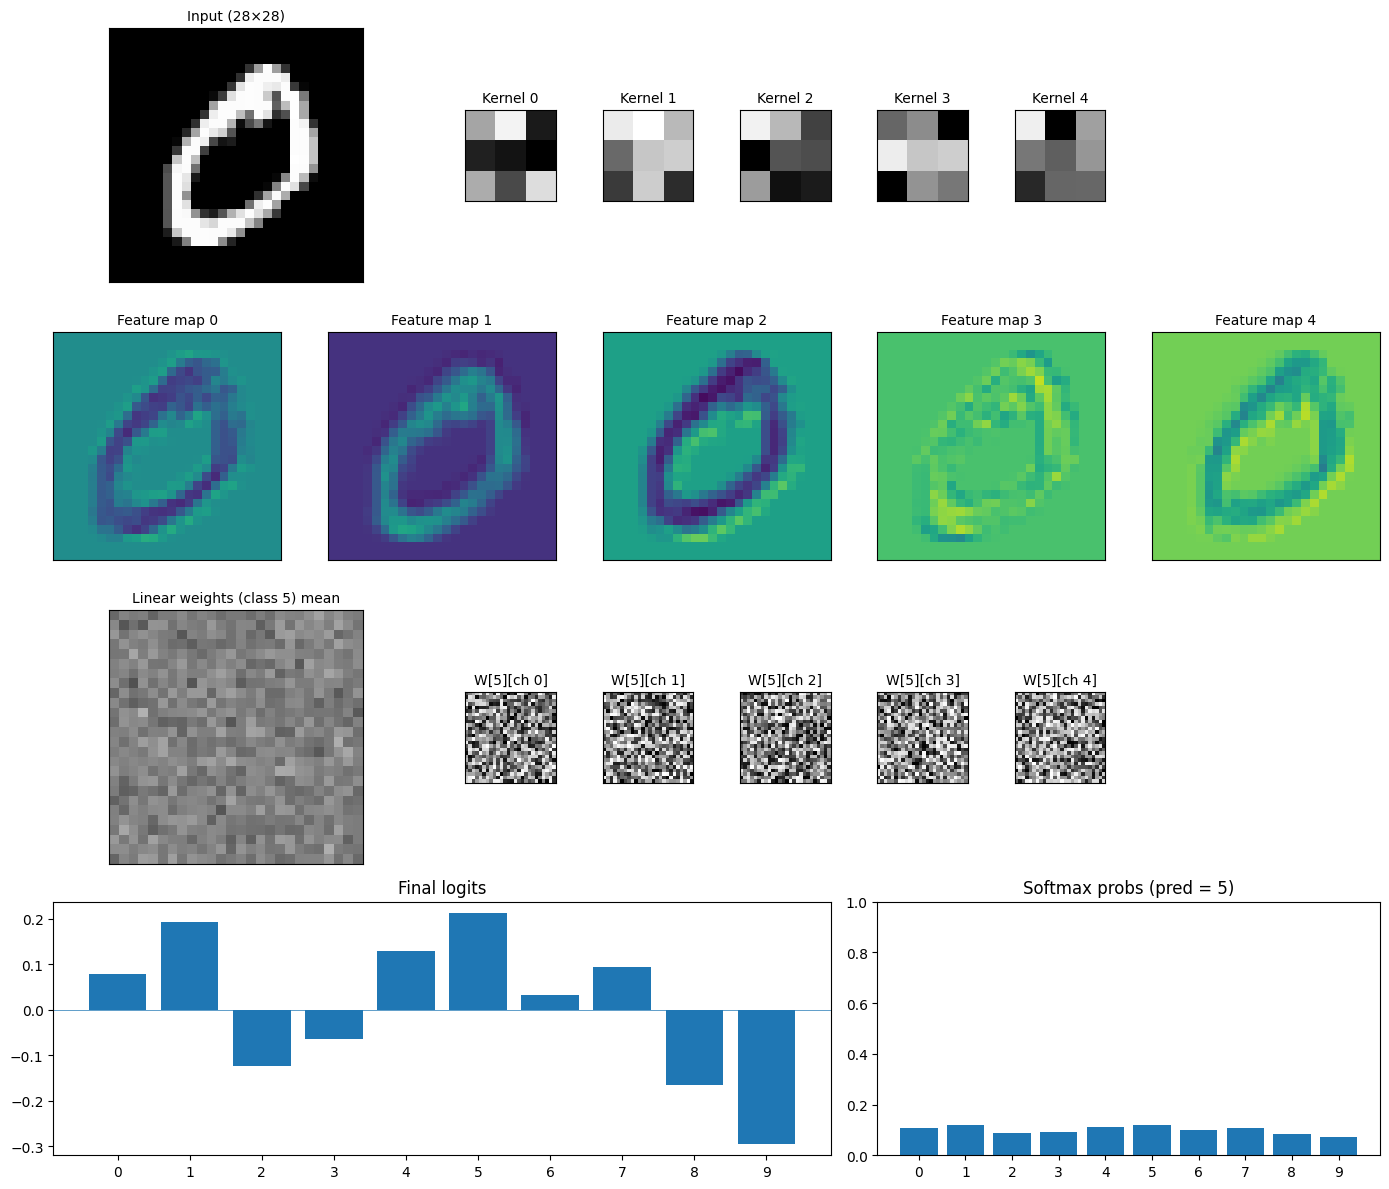

In [68]:
# Example usage
model = MNISTNetwork_CNN()
# Example single image x in shape [28,28] or [1,28,28]
x = x_train[1]
visualize_forward_pass(model, x, class_names=[str(i) for i in range(10)])

Note, the above indicates that the internal parameters for the convolutional layer are a stack of 20 weight tensors, each 1 x 3 x 3, because each is a 3x3 window of weights operating on an input of 1 feature. With a bias term to throw in.

### Training

In [59]:
loss_function = nn.CrossEntropyLoss()
optimizer_ff = optim.SGD( model_ff.parameters(), lr = 0.1 )
optimizer_cnn = optim.SGD( model_cnn.parameters(), lr = 0.1 )

In [60]:
epochs = 100

In [61]:
loss_history = []
cnn_history = []

In [62]:
batch_size = 64
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [63]:
from IPython.display import HTML, display

import IPython.display as disp
def append_log(text):
    js = f"""
    <script>
    var log = document.getElementById('train_log');
    log.textContent += `{text}\\n`;
    </script>
    """
    disp.display(HTML(js))


In [64]:
# Start log
display(HTML("<details><summary><b>Training Log (Click to Expand)</b></summary><pre id='train_log'></pre></details>"))

for epoch in range(epochs):
    total_loss_ff = 0
    total_loss_cnn = 0

    for x_batch, y_batch in train_loader:
        logits_ff = model_ff(x_batch)
        logits_cnn = model_cnn(x_batch)

        loss_ff = loss_function(logits_ff, y_batch)
        loss_cnn = loss_function(logits_cnn, y_batch)

        optimizer_ff.zero_grad()
        optimizer_cnn.zero_grad()

        loss_ff.backward()
        loss_cnn.backward()

        optimizer_ff.step()
        optimizer_cnn.step()

        total_loss_ff += loss_ff.item()
        total_loss_cnn += loss_cnn.item()

    avg_loss_cnn = total_loss_cnn / len(train_loader)
    avg_loss_ff = total_loss_ff / len(train_loader)

    loss_history.append(avg_loss_ff)
    cnn_history.append(avg_loss_cnn)
    append_log(f"Epoch {epoch+1:02d} | FF Loss: {avg_loss_ff:.6f} | CNN Loss: {avg_loss_cnn:.6f}")
    # print(f"Epoch {epoch+1}, FF Average Loss: {avg_loss_ff:.6f}, CNN Average Loss: {avg_loss_cnn:.6f}")


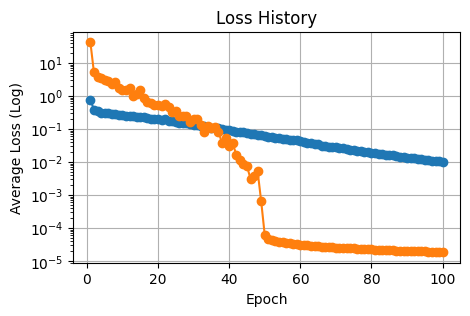

In [65]:
# Plotting the loss history
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.plot(range(1, len(cnn_history) + 1), cnn_history, marker='o', linestyle='-')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss (Log)")
plt.yscale("log")
plt.grid(True)
plt.show()

Note I am plotting the loss on a log scale above, just to make the comparison clearer. The simple dense model starts strong but decreases steadily - the cnn comes running and passes it. This kind of step behavior with a pretty dramatic decrease for the CNN is consistent in my experiments here - I think likely to do with the tanh activation function, and hitting a parameter regime where the inputs to the tanh activations become very responsive to parameter changes in ways they weren't previously.

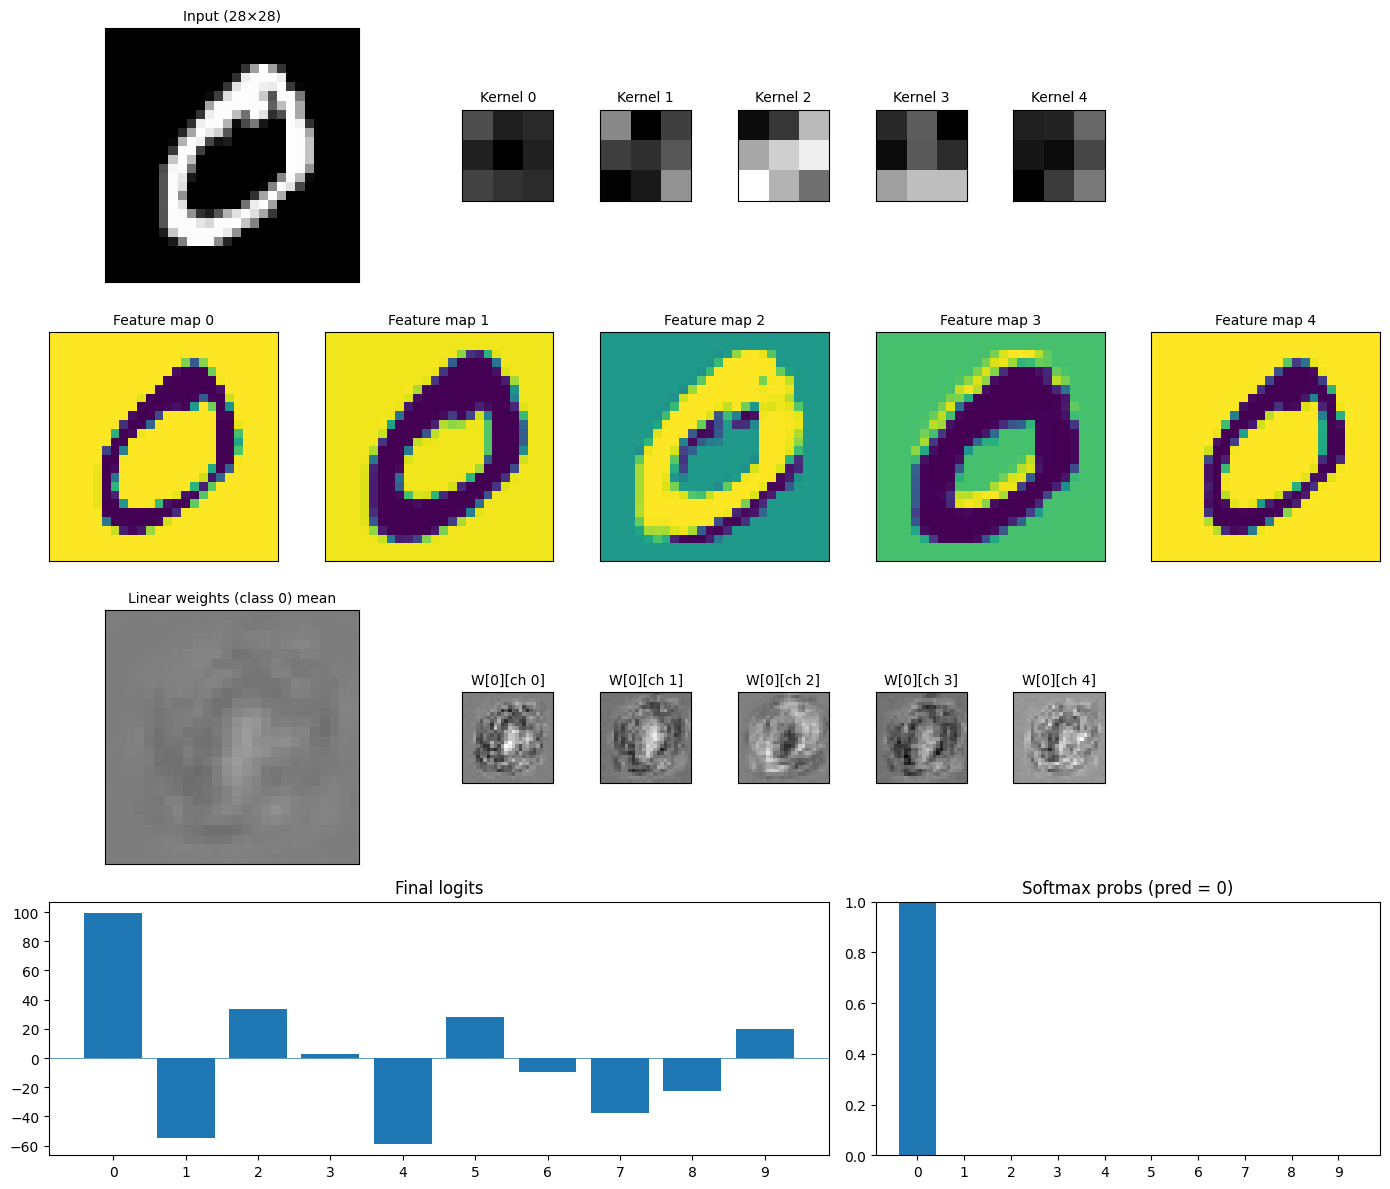

In [69]:
x = x_train[1]
visualize_forward_pass(model_cnn, x, class_names=[str(i) for i in range(10)])

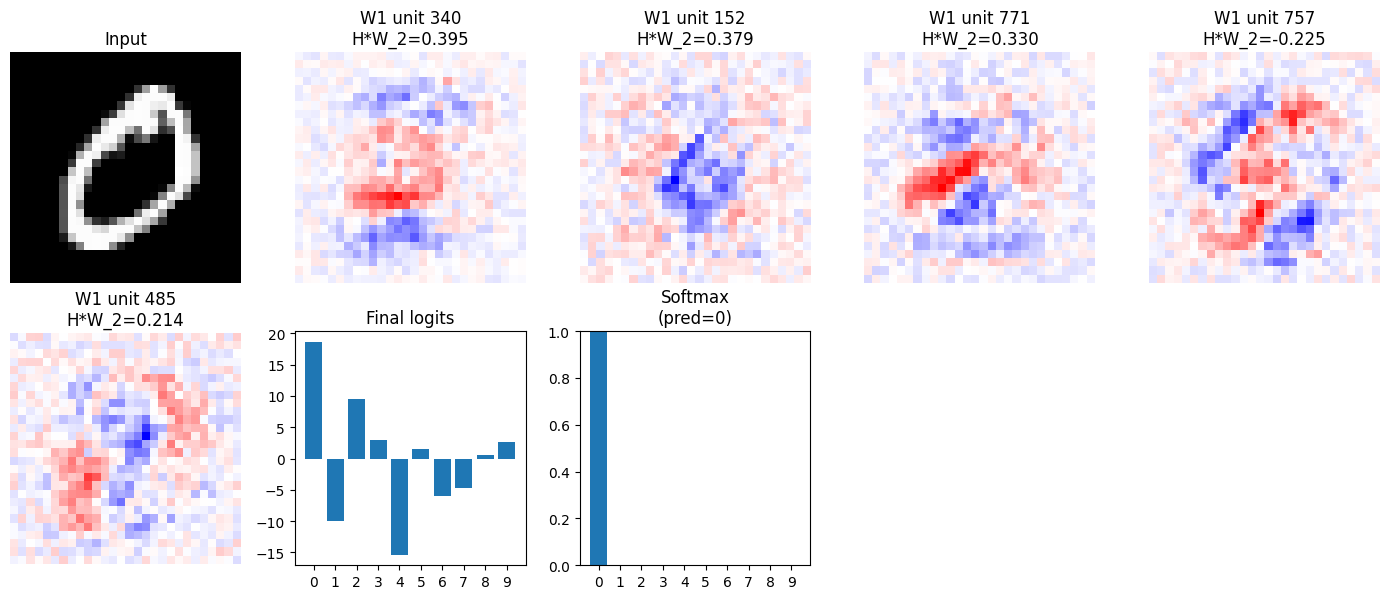

Predicted class: 0
Top-5 contributing units (indices): [340, 152, 771, 757, 485]
Their contributions: [ 0.3954246   0.37931123  0.33009475 -0.22466011  0.21434301]


In [20]:
visualize_forward_pass_ff(model_ff, x_train[1], class_names=[str(i) for i in range(10)])

### ReLU

Same thing, slightly different activation functions

In [21]:
class MNISTNetwork_FF(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = torch.nn.Linear( in_features = 784, out_features = 1000 )
    self.layer_2 = torch.nn.Linear( in_features = 1000, out_features = 10 )

  def forward(self, x):
    flattened = nn.Flatten()( x )
    hidden_nodes = self.layer_1( flattened )
    hidden_nodes = torch.nn.ReLU()( hidden_nodes )
    logits = self.layer_2( hidden_nodes )
    return logits

class MNISTNetwork_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = torch.nn.Conv2d( in_channels = 1, out_channels = 20, kernel_size = (3,3), stride = 1 )
    self.linear = torch.nn.Linear( in_features = 26*26*20, out_features = 10 )

  def forward(self, x, verbose = False):
    reshaped = torch.reshape( x, (-1, 1, 28, 28) )
    conv_results = self.conv_1( reshaped )
    conv_results = torch.nn.ReLU()( conv_results )
    flattened = torch.nn.Flatten()( conv_results )
    logits = self.linear( flattened )

    return logits

In [22]:
model_ff = MNISTNetwork_FF().to(device)
model_cnn = MNISTNetwork_CNN().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer_ff = optim.SGD( model_ff.parameters(), lr = 0.1 )
optimizer_cnn = optim.SGD( model_cnn.parameters(), lr = 0.1 )

ff_params = sum(p.numel() for p in model_ff.parameters() if p.requires_grad)
cnn_params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Feed-Forward network total parameters: {ff_params:,}")
print(f"Simple CNN total parameters: {cnn_params:,}")


cnn_test_loss = []
cnn_training_loss = []

dense_test_loss = []
dense_training_loss = []

for epoch in range(epochs):
    total_loss_ff = 0
    total_loss_cnn = 0

    for x_batch, y_batch in train_loader:
        logits_ff = model_ff(x_batch)
        logits_cnn = model_cnn(x_batch)

        loss_ff = loss_function(logits_ff, y_batch)
        loss_cnn = loss_function(logits_cnn, y_batch)

        optimizer_ff.zero_grad()
        optimizer_cnn.zero_grad()

        loss_ff.backward()
        loss_cnn.backward()

        optimizer_ff.step()
        optimizer_cnn.step()

        total_loss_ff += loss_ff.item()
        total_loss_cnn += loss_cnn.item()

    avg_loss_cnn = total_loss_cnn / len(train_loader)
    avg_loss_ff = total_loss_ff / len(train_loader)

    dense_training_loss.append(avg_loss_ff)
    cnn_training_loss.append(avg_loss_cnn)

    with torch.no_grad():
      logits_dense = model_ff( x_test )
      logits_cnn = model_cnn( x_test )
      dense_test_loss.append( loss_function(logits_dense, y_test ).item() )
      cnn_test_loss.append( loss_function(logits_cnn, y_test).item() )

    # print(f"Epoch {epoch+1}, FF Average Loss: {avg_loss_ff:.6f}, CNN Average Loss: {avg_loss_cnn:.6f}")



Feed-Forward network total parameters: 795,010
Simple CNN total parameters: 135,410


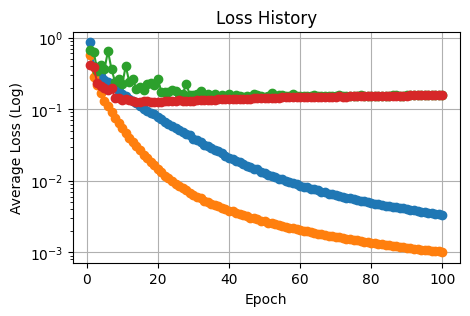

In [23]:
# Plotting the loss history
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(dense_training_loss) + 1), ( dense_training_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(cnn_training_loss) + 1), ( cnn_training_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(dense_test_loss) + 1), ( dense_test_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(cnn_test_loss) + 1), cnn_test_loss, marker='o', linestyle='-')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss (Log)")
plt.yscale("log")
plt.grid(True)
plt.show()

We see, interestingly, no similar fall off on the CNN network. My read on this is that because ReLU doesn't have the same plateaus that Tanh does (at least not on one side), feature learning is 'responsive/efficient' at a wider range of parameter values for ReLU nodes.

In the above, the green represents the test loss (log scale) for the dense network, red for the cnn network. We see that the test loss is also superior faster, though they both start to demonstrate overfitting (seems to me, with the rise in both curves). We can see from this that we get a dramatically improved performance in much less training time with the CNN network.

(The reason being, as I am hoping to discuss tomorrow, is the fact that features are being learned to be useful based on local data across the entire input field - essentially multiplying the data for a single feature by the size of the image.)

## Stacking

In [24]:
class MNISTNetwork_CNN_Stacked(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = torch.nn.Conv2d( in_channels = 1, out_channels = 20, kernel_size = (3,3), stride = 1 )
    self.conv_2 = torch.nn.Conv2d( in_channels = 20, out_channels = 10, kernel_size = (2,2), stride = 1 )
    self.linear = torch.nn.Linear( in_features = 25*25*10, out_features = 10 )

  def forward(self, x, verbose = False):

    if verbose:
      print("Input Dimension:", x.shape)

    reshaped = torch.reshape( x, (-1, 1, 28, 28) )

    if verbose:
      print("Reshaped for CNN use:", reshaped.shape)

    conv_results = self.conv_1( reshaped )

    if verbose:
      print("After applying the first CNN layer:", conv_results.shape )

    conv_results = torch.nn.ReLU()( conv_results )

    conv_results = self.conv_2( conv_results )

    if verbose:
      print("After applying the second CNN layer:", conv_results.shape )


    flattened = torch.nn.Flatten()( conv_results ) ## Flatten the results to a single linear vector, which we can then pass into a normal linear transformation

    if verbose:
      print("Flattened shape:", flattened.shape)

    logits = self.linear( flattened ) ## Compute the logits

    if verbose:
      print("Final Output:", logits.shape)

    return logits

In [25]:
model_cnn_stacked = MNISTNetwork_CNN_Stacked().to(device)

In [26]:
model_cnn_stacked( x_train_small, verbose = True)

Input Dimension: torch.Size([10000, 28, 28])
Reshaped for CNN use: torch.Size([10000, 1, 28, 28])
After applying the first CNN layer: torch.Size([10000, 20, 26, 26])
After applying the second CNN layer: torch.Size([10000, 10, 25, 25])
Flattened shape: torch.Size([10000, 6250])
Final Output: torch.Size([10000, 10])


tensor([[ 0.1394,  0.1039, -0.0469,  ...,  0.0176,  0.0421, -0.0872],
        [ 0.1007,  0.0761,  0.0517,  ..., -0.0424, -0.0106, -0.0659],
        [ 0.1058,  0.0507,  0.0037,  ...,  0.0140,  0.0496, -0.0891],
        ...,
        [ 0.0591,  0.0579, -0.0445,  ..., -0.0103,  0.1390, -0.0887],
        [ 0.0864,  0.0447,  0.0376,  ...,  0.0319,  0.0234, -0.1300],
        [ 0.0757,  0.0430, -0.0063,  ..., -0.0321,  0.0319, -0.0636]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

Epoch 1, FF Average Loss: 1.125743, CNN Average Loss: 1.300016
Epoch 2, FF Average Loss: 0.489317, CNN Average Loss: 0.443552
Epoch 3, FF Average Loss: 0.397598, CNN Average Loss: 0.365973
Epoch 4, FF Average Loss: 0.353566, CNN Average Loss: 0.332652
Epoch 5, FF Average Loss: 0.335504, CNN Average Loss: 0.319465
Epoch 6, FF Average Loss: 0.319498, CNN Average Loss: 0.304795
Epoch 7, FF Average Loss: 0.305371, CNN Average Loss: 0.295084
Epoch 8, FF Average Loss: 0.295931, CNN Average Loss: 0.289456
Epoch 9, FF Average Loss: 0.284207, CNN Average Loss: 0.279957
Epoch 10, FF Average Loss: 0.273003, CNN Average Loss: 0.273472
Epoch 11, FF Average Loss: 0.263641, CNN Average Loss: 0.266553
Epoch 12, FF Average Loss: 0.252807, CNN Average Loss: 0.260252
Epoch 13, FF Average Loss: 0.246517, CNN Average Loss: 0.257053
Epoch 14, FF Average Loss: 0.239029, CNN Average Loss: 0.252062
Epoch 15, FF Average Loss: 0.236292, CNN Average Loss: 0.249699
Epoch 16, FF Average Loss: 0.228387, CNN Average 

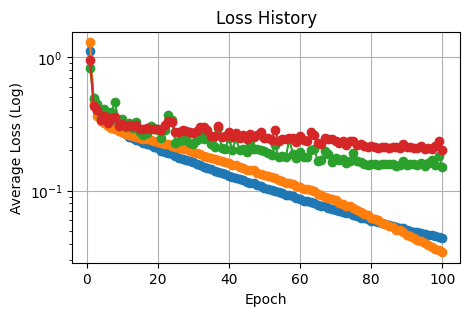

In [27]:
model_ff = MNISTNetwork_CNN().to(device)
model_cnn = MNISTNetwork_CNN_Stacked().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer_ff = optim.SGD( model_ff.parameters(), lr = 0.01 )
optimizer_cnn = optim.SGD( model_cnn.parameters(), lr = 0.01 )


cnn_test_loss = []
cnn_training_loss = []

dense_test_loss = []
dense_training_loss = []

for epoch in range(epochs):
    total_loss_ff = 0
    total_loss_cnn = 0

    for x_batch, y_batch in train_loader:
        logits_ff = model_ff(x_batch)
        logits_cnn = model_cnn(x_batch)

        loss_ff = loss_function(logits_ff, y_batch)
        loss_cnn = loss_function(logits_cnn, y_batch)

        optimizer_ff.zero_grad()
        optimizer_cnn.zero_grad()

        loss_ff.backward()
        loss_cnn.backward()

        optimizer_ff.step()
        optimizer_cnn.step()

        total_loss_ff += loss_ff.item()
        total_loss_cnn += loss_cnn.item()

    avg_loss_cnn = total_loss_cnn / len(train_loader)
    avg_loss_ff = total_loss_ff / len(train_loader)

    dense_training_loss.append(avg_loss_ff)
    cnn_training_loss.append(avg_loss_cnn)

    with torch.no_grad():
      logits_dense = model_ff( x_test )
      logits_cnn = model_cnn( x_test )
      dense_test_loss.append( loss_function(logits_dense, y_test ).item() )
      cnn_test_loss.append( loss_function(logits_cnn, y_test).item() )


    print(f"Epoch {epoch+1}, FF Average Loss: {avg_loss_ff:.6f}, CNN Average Loss: {avg_loss_cnn:.6f}")

# Plotting the loss history
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(dense_training_loss) + 1), ( dense_training_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(cnn_training_loss) + 1), ( cnn_training_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(dense_test_loss) + 1), ( dense_test_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(cnn_test_loss) + 1), ( cnn_test_loss ), marker='o', linestyle='-')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss (Log)")
plt.yscale("log")
plt.grid(True)
plt.show()

Stacking, we get more complex features, which we can leverage for a better fit. I think it's itneresting to note here that we get more complex training dynamics as well - appearances of plateaus in the test loss for the stacked CNN model.

In [28]:
class MNISTNetwork_CNN_Stacked_2(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_1 = torch.nn.Conv2d( in_channels = 1, out_channels = 20, kernel_size = (3,3), stride = 1 )
    self.conv_2 = torch.nn.Conv2d( in_channels = 20, out_channels = 10, kernel_size = (2,2), stride = 1 )


    self.linear_1 = torch.nn.Linear( in_features = 25*25*10, out_features = 1000 )
    self.linear_2 = torch.nn.Linear( in_features = 1000, out_features = 10 )

  def forward(self, x, verbose = False):

    if verbose:
      print("Input Dimension:", x.shape)

    reshaped = torch.reshape( x, (-1, 1, 28, 28) )

    if verbose:
      print("Reshaped for CNN use:", reshaped.shape)

    conv_results = self.conv_1( reshaped )

    if verbose:
      print("After applying the first CNN layer:", conv_results.shape )

    conv_results = torch.nn.ReLU()( conv_results )

    conv_results = self.conv_2( conv_results )

    if verbose:
      print("After applying the second CNN layer:", conv_results.shape )


    flattened = torch.nn.Flatten()( conv_results ) ## Flatten the results to a single linear vector, which we can then pass into a normal linear transformation

    if verbose:
      print("Flattened shape:", flattened.shape)

    hidden_nodes = self.linear_1( flattened )

    if verbose:
      print("After the first linear layer:", hidden_nodes.shape )

    hidden_nodes = torch.nn.ReLU()( hidden_nodes )



    logits = self.linear_2( hidden_nodes ) ## Compute the logits

    if verbose:
      print("Final Output:", logits.shape)

    return logits

In [29]:
model_cnn_stacked_2 = MNISTNetwork_CNN_Stacked_2().to(device)

In [30]:
model_cnn_stacked_2( x_train_small, verbose = True)

Input Dimension: torch.Size([10000, 28, 28])
Reshaped for CNN use: torch.Size([10000, 1, 28, 28])
After applying the first CNN layer: torch.Size([10000, 20, 26, 26])
After applying the second CNN layer: torch.Size([10000, 10, 25, 25])
Flattened shape: torch.Size([10000, 6250])
After the first linear layer: torch.Size([10000, 1000])
Final Output: torch.Size([10000, 10])


tensor([[-8.0135e-03, -5.8117e-03,  3.3788e-02,  ..., -4.7850e-02,
         -1.0037e-03, -5.0311e-03],
        [ 7.3050e-03, -9.2355e-03,  1.3357e-02,  ..., -6.1972e-02,
          1.1935e-02,  9.2479e-04],
        [ 2.6316e-03, -1.8291e-02,  2.8248e-02,  ..., -2.7356e-02,
          1.8862e-02, -3.7652e-02],
        ...,
        [ 1.0015e-05, -1.4619e-02,  1.7558e-02,  ..., -4.9391e-02,
          2.0046e-02, -4.3010e-02],
        [-1.2003e-02, -1.3706e-02,  9.1285e-03,  ..., -6.3906e-02,
         -1.6432e-02, -1.4093e-02],
        [ 3.7078e-03, -1.6431e-02,  1.0932e-02,  ..., -4.5126e-02,
          2.1702e-02, -2.7688e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)

Epoch 1, FF Average Loss: 1.311861, CNN Average Loss: 2.115520
Epoch 2, FF Average Loss: 0.425736, CNN Average Loss: 0.769878
Epoch 3, FF Average Loss: 0.352540, CNN Average Loss: 0.436034
Epoch 4, FF Average Loss: 0.323502, CNN Average Loss: 0.355512
Epoch 5, FF Average Loss: 0.307984, CNN Average Loss: 0.318820
Epoch 6, FF Average Loss: 0.294742, CNN Average Loss: 0.284837
Epoch 7, FF Average Loss: 0.286055, CNN Average Loss: 0.261660
Epoch 8, FF Average Loss: 0.277526, CNN Average Loss: 0.237837
Epoch 9, FF Average Loss: 0.271089, CNN Average Loss: 0.217129
Epoch 10, FF Average Loss: 0.267331, CNN Average Loss: 0.199647
Epoch 11, FF Average Loss: 0.261292, CNN Average Loss: 0.184096
Epoch 12, FF Average Loss: 0.258133, CNN Average Loss: 0.166833
Epoch 13, FF Average Loss: 0.253034, CNN Average Loss: 0.154668
Epoch 14, FF Average Loss: 0.249146, CNN Average Loss: 0.141925
Epoch 15, FF Average Loss: 0.245976, CNN Average Loss: 0.131090
Epoch 16, FF Average Loss: 0.243750, CNN Average 

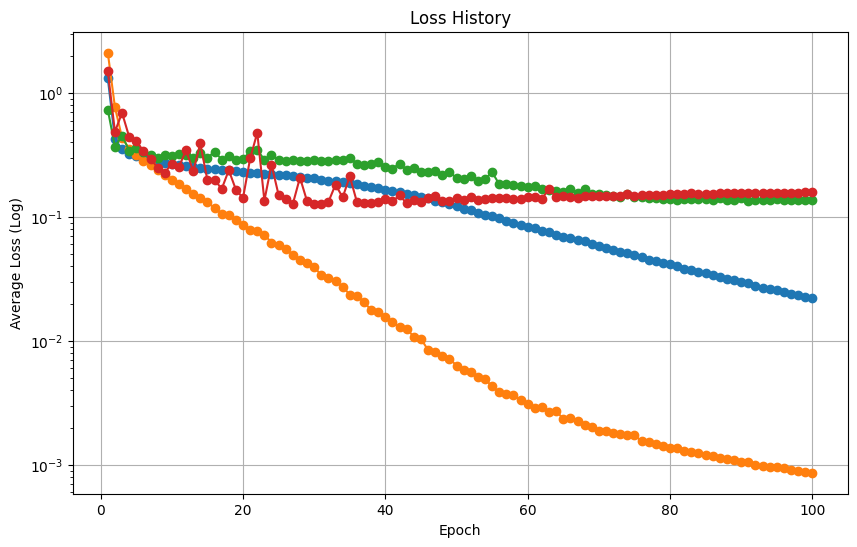

In [31]:
model_ff = MNISTNetwork_CNN_Stacked().to(device)
model_cnn = MNISTNetwork_CNN_Stacked_2().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer_ff = optim.SGD( model_ff.parameters(), lr = 0.01 )
optimizer_cnn = optim.SGD( model_cnn.parameters(), lr = 0.01 )


cnn_test_loss = []
cnn_training_loss = []

dense_test_loss = []
dense_training_loss = []

for epoch in range(epochs):
    total_loss_ff = 0
    total_loss_cnn = 0

    for x_batch, y_batch in train_loader:
        logits_ff = model_ff(x_batch)
        logits_cnn = model_cnn(x_batch)

        loss_ff = loss_function(logits_ff, y_batch)
        loss_cnn = loss_function(logits_cnn, y_batch)

        optimizer_ff.zero_grad()
        optimizer_cnn.zero_grad()

        loss_ff.backward()
        loss_cnn.backward()

        optimizer_ff.step()
        optimizer_cnn.step()

        total_loss_ff += loss_ff.item()
        total_loss_cnn += loss_cnn.item()

    avg_loss_cnn = total_loss_cnn / len(train_loader)
    avg_loss_ff = total_loss_ff / len(train_loader)

    dense_training_loss.append(avg_loss_ff)
    cnn_training_loss.append(avg_loss_cnn)

    with torch.no_grad():
      logits_dense = model_ff( x_test )
      logits_cnn = model_cnn( x_test )
      dense_test_loss.append( loss_function(logits_dense, y_test ).item() )
      cnn_test_loss.append( loss_function(logits_cnn, y_test).item() )


    print(f"Epoch {epoch+1}, FF Average Loss: {avg_loss_ff:.6f}, CNN Average Loss: {avg_loss_cnn:.6f}")

# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(dense_training_loss) + 1), ( dense_training_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(cnn_training_loss) + 1), ( cnn_training_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(dense_test_loss) + 1), ( dense_test_loss ), marker='o', linestyle='-')
plt.plot(range(1, len(cnn_test_loss) + 1), ( cnn_test_loss ), marker='o', linestyle='-')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss (Log)")
plt.yscale("log")
plt.grid(True)
plt.show()

Adding a second linear layer improves performance still - we definitely see the increase indicating overfitting (in red) for the new network, but we get a superior loss faster.

At this point I need to call it a night. I don't know how much you'll have time to get through in recitation - I am anticipating a number of questions about dimensions and how the CNN changes things and how to know what the resulting dimensions are going to be etc. Be ready to draw pictures, and run experiments (I find printing out the dimensions as the computation goes through the forward function to be really useful.)

I also am hoping to get into both pooling layers and dropout tomorrow (I'm being ambitious, as ever) so if you want to work in some examples of that as well, I think that'd be a good thing.

One thing you might do - take prompts from students to construct various network shapes, sizes, etc, and see what changes and how. Note that in one of my examples above I actually had to decrease the stepsize to stabilize training. But the payoff was better results.

## Max Pooling

In [32]:
# In this part, we will define two similar stacked CNNs.
# 1. CNN_Stacked_No_Pool: Similar to the previous stacked CNN.
# 2. CNN_Stacked_With_Pool: Adds a MaxPool2d layer after each conv layer.
# Our goal is to see the impact on training speed and performance (accuracy).

import time
import torch.nn.functional as F

# Definitions
class CNN_Stacked_No_Pool(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3,3), stride=1)
        # Output: 20 x 26 x 26
        self.conv_2 = torch.nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(2,2), stride=1)
        # Output: 10 x 25 x 25
        self.linear = torch.nn.Linear(in_features=25*25*10, out_features=10)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28))
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = torch.nn.Flatten()(x)
        logits = self.linear(x)
        return logits

class CNN_Stacked_With_Pool(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3,3), stride=1)
        # Input: 1x28x28 -> Conv1 -> 20x26x26
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool1 -> 20x13x13

        # Layer 2
        self.conv_2 = torch.nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(2,2), stride=1)
        # Input: 20x13x13 -> Conv2 -> 10x12x12
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool2 -> 10x6x6

        # You can point out to students that the input features for the linear layer is much smaller now!
        # 10 * 6 * 6 = 360, compared to 6250 for the no-pooling version.
        self.linear = torch.nn.Linear(in_features=10*6*6, out_features=10)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28))
        x = self.pool_1(F.relu(self.conv_1(x)))
        x = self.pool_2(F.relu(self.conv_2(x)))
        x = torch.nn.Flatten()(x)
        logits = self.linear(x)
        return logits

# Training and Evaluation
def train_and_eval(model, optimizer, model_name):
    print(f"Training {model_name}")
    start_time = time.time()
    test_accuracy_history = []
    epochs_pool = 30 # A shorter training is enough to see the effect

    for epoch in range(epochs_pool):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = loss_function(logits, y_batch)
            loss.backward()
            optimizer.step()

        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            logits_test = model(x_test)
            _, predicted = torch.max(logits_test.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

        accuracy = 100 * correct / total
        test_accuracy_history.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs_pool}, Test Accuracy: {accuracy:.2f}%")

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Total training time for {model_name}: {training_time:.2f} seconds")
    return test_accuracy_history, training_time

# Run
# No pooling ,odel
model_no_pool = CNN_Stacked_No_Pool().to(device)
optimizer_no_pool = optim.SGD(model_no_pool.parameters(), lr=0.01)
acc_history_no_pool, time_no_pool = train_and_eval(model_no_pool, optimizer_no_pool, "No Pooling CNN")

print("\n" + "="*50 + "\n")

# With pooling model
model_with_pool = CNN_Stacked_With_Pool().to(device)
optimizer_with_pool = optim.SGD(model_with_pool.parameters(), lr=0.01)
acc_history_with_pool, time_with_pool = train_and_eval(model_with_pool, optimizer_with_pool, "With Pooling CNN")

# Parameter count comparison (no pool vs. with pool) ---
no_pool_params = sum(p.numel() for p in model_no_pool.parameters() if p.requires_grad)
with_pool_params = sum(p.numel() for p in model_with_pool.parameters() if p.requires_grad)
print(f"Stacked CNN (no pooling) total parameters: {no_pool_params:,}")
print(f"Stacked CNN (with pooling) total parameters: {with_pool_params:,}")


Training No Pooling CNN
Epoch 1/30, Test Accuracy: 74.18%
Epoch 2/30, Test Accuracy: 87.72%
Epoch 3/30, Test Accuracy: 85.84%
Epoch 4/30, Test Accuracy: 80.37%
Epoch 5/30, Test Accuracy: 86.32%
Epoch 6/30, Test Accuracy: 88.58%
Epoch 7/30, Test Accuracy: 90.59%
Epoch 8/30, Test Accuracy: 87.34%
Epoch 9/30, Test Accuracy: 90.30%
Epoch 10/30, Test Accuracy: 85.15%
Epoch 11/30, Test Accuracy: 91.31%
Epoch 12/30, Test Accuracy: 91.96%
Epoch 13/30, Test Accuracy: 91.97%
Epoch 14/30, Test Accuracy: 90.34%
Epoch 15/30, Test Accuracy: 91.61%
Epoch 16/30, Test Accuracy: 89.92%
Epoch 17/30, Test Accuracy: 89.51%
Epoch 18/30, Test Accuracy: 89.39%
Epoch 19/30, Test Accuracy: 84.31%
Epoch 20/30, Test Accuracy: 90.83%
Epoch 21/30, Test Accuracy: 91.32%
Epoch 22/30, Test Accuracy: 92.11%
Epoch 23/30, Test Accuracy: 89.41%
Epoch 24/30, Test Accuracy: 85.07%
Epoch 25/30, Test Accuracy: 91.93%
Epoch 26/30, Test Accuracy: 88.59%
Epoch 27/30, Test Accuracy: 86.58%
Epoch 28/30, Test Accuracy: 92.57%
Epoch

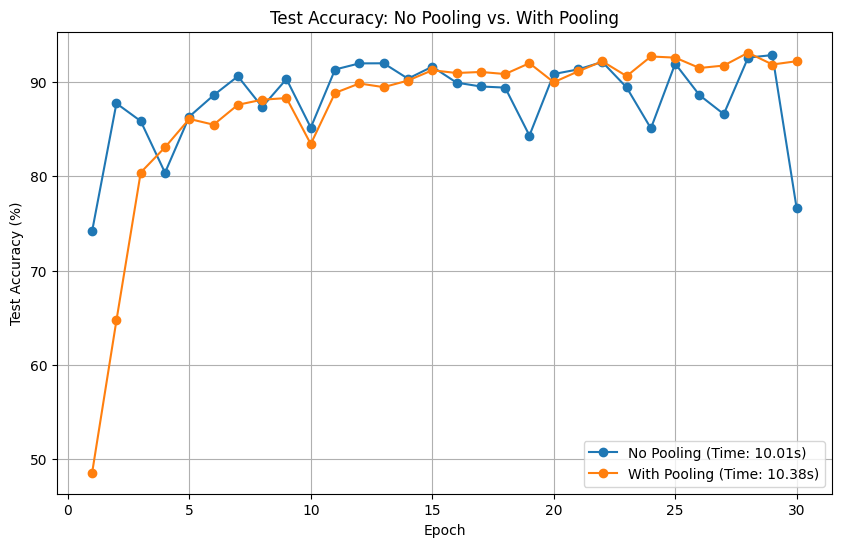

In [33]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(acc_history_no_pool) + 1), acc_history_no_pool, marker='o', linestyle='-', label=f'No Pooling (Time: {time_no_pool:.2f}s)')
plt.plot(range(1, len(acc_history_with_pool) + 1), acc_history_with_pool, marker='o', linestyle='-', label=f'With Pooling (Time: {time_with_pool:.2f}s)')
plt.title("Test Accuracy: No Pooling vs. With Pooling")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
#@title visualize maxpool
from math import ceil

@torch.no_grad()
def visualize_pre_post_pool(
    model,
    images,                    # A batch tensor (N, 28*28) or (N, 1, 28, 28)
    which_layer: int = 1,      # 1 for (conv_1 -> pool_1), 2 for (conv_2 -> pool_2)
    sample_index: int = 0,     # Which image in the batch to visualize
    topk_channels: int = 6,    # How many channels to show (picked by mean activation)
    use_relu: bool = True,     # Apply ReLU before pooling (matches your forward)
    device: torch.device = None
):
    """
    Visualizes 'input image' vs. feature map BEFORE pooling vs. AFTER pooling.

    - Works for both CNN_Stacked_No_Pool and CNN_Stacked_With_Pool.
    - If the model has no pooling layers, we simulate them with F.max_pool2d
      so you can still see the effect.

    Args:
        model: trained CNN (your CNN_Stacked_No_Pool or CNN_Stacked_With_Pool).
        images: batch of images (N, 28*28) or (N, 1, 28, 28) on CPU or GPU.
        which_layer: 1 or 2 (first or second conv/pool pair).
        sample_index: which sample in the batch to visualize.
        topk_channels: pick the top-k most active channels to display.
        use_relu: apply ReLU before pooling (as in your forward passes).
        device: torch.device (auto-detected if None).
    """
    assert which_layer in (1, 2), "which_layer must be 1 or 2"

    # ---- Prep ----------------------------------------------------------------
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    # Ensure (N, 1, 28, 28)
    if images.dim() == 2:
        images_v = images.view(-1, 1, 28, 28).to(device)
    elif images.dim() == 4:
        images_v = images.to(device)
    else:
        raise ValueError("images must be shaped (N, 28*28) or (N, 1, 28, 28)")

    # Clamp sample index
    sample_index = max(0, min(sample_index, images_v.size(0) - 1))

    # ---- Forward until the chosen layer -------------------------------------
    x = images_v

    # Layer 1 conv output
    z1 = model.conv_1(x)
    a1 = F.relu(z1) if use_relu else z1

    # Use model's pool_1 if it exists; otherwise simulate
    has_pool1 = hasattr(model, "pool_1") and isinstance(getattr(model, "pool_1"), torch.nn.MaxPool2d)
    p1 = model.pool_1(a1) if has_pool1 else F.max_pool2d(a1, kernel_size=2, stride=2)

    if which_layer == 1:
        before = a1
        after  = p1
        layer_name = "Layer 1 (Conv1 → Pool1)"
    else:
        # Layer 2 conv takes either pooled output (with-pool model) or the unpooled (no-pool model)
        # To keep the comparison apples-to-apples, we feed the *pooled* activations into conv_2
        # if the model has pool_1; otherwise we feed a1 directly (matching your no-pool forward).
        conv2_input = p1 if has_pool1 else a1

        z2 = model.conv_2(conv2_input)
        a2 = F.relu(z2) if use_relu else z2

        # Use model's pool_2 if it exists; otherwise simulate
        has_pool2 = hasattr(model, "pool_2") and isinstance(getattr(model, "pool_2"), torch.nn.MaxPool2d)
        p2 = model.pool_2(a2) if has_pool2 else F.max_pool2d(a2, kernel_size=2, stride=2)

        before = a2
        after  = p2
        layer_name = "Layer 2 (Conv2 → Pool2)"

    # ---- Pick top-k channels by mean activation ------------------------------
    # Shape: (N, C, H, W)
    activ_means = before.mean(dim=(2, 3))  # (N, C)
    sample_means = activ_means[sample_index]
    k = min(topk_channels, sample_means.numel())
    topk_vals, topk_idx = torch.topk(sample_means, k=k, largest=True, sorted=True)

    # ---- Plot grid: original | before-pool | after-pool for each chosen channel
    img_np = images_v[sample_index, 0].detach().float().cpu().numpy()

    # Clean figure
    rows = k
    cols = 3
    fig_h = max(3, rows * 2.2)
    fig_w = 3 * 3.2
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    if rows == 1:
        axes = axes.reshape(1, -1)

    # Titles for columns
    col_titles = ["Input (28×28)", f"Before Pool ({list(before.shape[2:])})", f"After Pool ({list(after.shape[2:])})"]

    for c in range(cols):
        axes[0, c].set_title(col_titles[c], fontsize=12)

    for r, ch in enumerate(topk_idx.tolist()):
        # Column 1: original input
        ax0 = axes[r, 0]
        ax0.imshow(img_np, cmap="gray")
        ax0.axis("off")
        if r == 0:
            ax0.set_title(col_titles[0], fontsize=12)

        # Column 2: before pooling (feature map at channel ch)
        fmap_before = before[sample_index, ch].detach().float().cpu().numpy()
        ax1 = axes[r, 1]
        ax1.imshow(fmap_before, cmap="gray")
        ax1.axis("off")
        if r == 0:
            ax1.set_title(col_titles[1], fontsize=12)

        # Column 3: after pooling (same channel index)
        # Note: channel count is unchanged by pooling, so indexing ch is valid.
        fmap_after = after[sample_index, ch].detach().float().cpu().numpy()
        ax2 = axes[r, 2]
        ax2.imshow(fmap_after, cmap="gray")
        ax2.axis("off")
        if r == 0:
            ax2.set_title(col_titles[2], fontsize=12)

        # Row label with channel id and mean activation
        axes[r, 0].set_ylabel(f"ch {ch}\nμ={sample_means[ch]:.2f}", rotation=0, labelpad=30, va="center", ha="left", fontsize=10)

    plt.suptitle(f"MaxPool Effect • {layer_name}", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

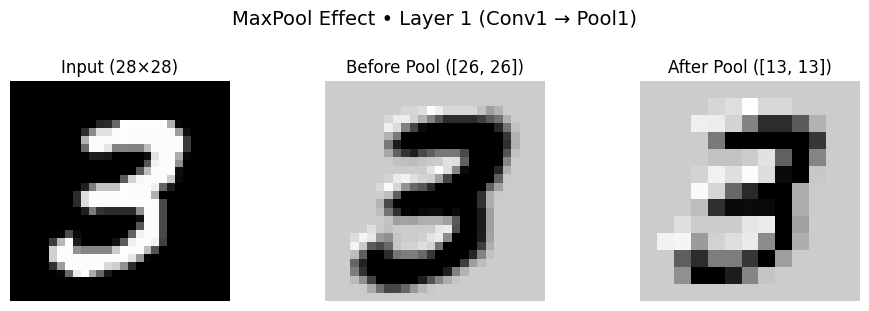

In [45]:
batch = x_train[7]  # any small batch
visualize_pre_post_pool(model_with_pool, batch, which_layer=1, sample_index=0, topk_channels=1)
# visualize_pre_post_pool(model_with_pool, batch, which_layer=2, sample_index=0, topk_channels=1)


## Dropouts

In [ ]:
class DeepNN(nn.Module):
  def __init__(self, dropout=False):
      super().__init__()

      layers = []
      in_features = 784
      hidden_size = 500
      num_hidden_layers = 9
      dropout_rate = 0.3

      # Hidden layers
      for _ in range(num_hidden_layers):
          layers.append(nn.Linear(in_features, hidden_size))
          layers.append(nn.ReLU())
          if dropout:
              layers.append(nn.Dropout(dropout_rate))
          in_features = hidden_size  # for next layer

      # Final output layer
      layers.append(nn.Linear(hidden_size, 10))

      self.model = nn.Sequential(*layers)
      self.flatten = nn.Flatten()

  def forward(self, x):
      x = self.flatten(x)
      return self.model(x)

In [ ]:
from tqdm import tqdm

# models, losses, optimizers
model = DeepNN(dropout=False).to(device)
model_2 = DeepNN(dropout=True).to(device)

loss_function = nn.CrossEntropyLoss()
loss_function_2 = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.05)
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.05)

loss_history, test_history = [], []
loss_history_2, test_history_2 = [], []

epochs = 200
for epoch in tqdm(range(epochs), desc="Training"):
    model.train()
    model_2.train()

    total_loss = 0.0
    total_loss_2 = 0.0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # model 1
        logits = model(x_batch)
        loss = loss_function(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # model 2 (with dropout)
        logits_2 = model_2(x_batch)
        loss_2 = loss_function_2(logits_2, y_batch)
        optimizer_2.zero_grad()
        loss_2.backward()
        optimizer_2.step()
        total_loss_2 += loss_2.item()

    # training averages
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    avg_loss_2 = total_loss_2 / len(train_loader)
    loss_history_2.append(avg_loss_2)

    # evaluation
    model.eval()
    model_2.eval()
    with torch.no_grad():
        xt = x_test.to(device)
        yt = y_test.to(device)

        logits = model(xt)
        test_loss = loss_function(logits, yt)
        test_history.append(test_loss.item())

        logits_2  = model_2(xt)
        test_loss_2 = loss_function_2(logits_2, yt)
        test_history_2.append(test_loss_2.item())


Training: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


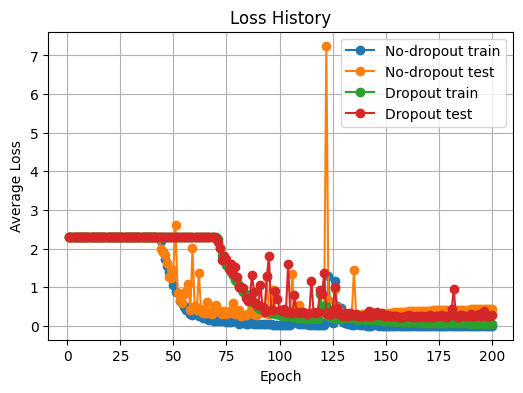

In [ ]:

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', label="No-dropout train")
plt.plot(range(1, len(test_history) + 1), test_history, marker='o', linestyle='-', label="No-dropout test")
plt.plot(range(1, len(loss_history_2) + 1), loss_history_2, marker='o', linestyle='-', label="Dropout train")
plt.plot(range(1, len(test_history_2) + 1), test_history_2, marker='o', linestyle='-', label="Dropout test")
plt.legend()
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

Took a minute to enter a decent decrease regime - but comparing this graph to the previous graph, we see that inclusion of dropout significantly improved generalization.

Much to consider.

## Others: CNN on CIFAR-10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Data loading and preprocessing
# CIFAR-10 images are 3x32x32 color images.
# We need to normalize them, which is a common step for color images.
transform = transforms.Compose(
    [transforms.ToTensor(),
     # Normalization: Set mean and std to 0.5 for all three channels.
     # This will transform the pixel values from the [0, 1] range to the [-1, 1] range.
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the batch size
batch_size_cifar = 64

# Download and load the training set
trainset_cifar = torchvision.datasets.CIFAR10(root='./data_cifar', train=True, download=True, transform=transform)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=batch_size_cifar, shuffle=True, num_workers=2)

# Download and load the test set
testset_cifar = torchvision.datasets.CIFAR10(root='./data_cifar', train=False, download=True, transform=transform)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size_cifar, shuffle=False, num_workers=2)

# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [02:16<00:00, 1.25MB/s]


few example images from the CIFAR-10 dataset


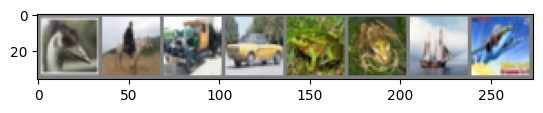

Labels:  bird  horse truck car   frog  frog  ship  plane


In [ ]:
# Visualizing the CIFAR-10 Dataset

# Helper function to show an image
def imshow(img):
    # Un-normalize the image
    # The normalization was (data - 0.5) / 0.5. To reverse it, we do (data * 0.5) + 0.5
    img = img / 2 + 0.5
    npimg = img.numpy()
    # Transpose the dimensions from (Channel, Height, Width) to (Height, Width, Channel) for display
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
# We use an iterator on the trainloader to grab one batch
dataiter = iter(trainloader_cifar)
images, labels = next(dataiter)

# Show images
print("few example images from the CIFAR-10 dataset")
# Use torchvision.utils.make_grid to arrange images in a grid
imshow(torchvision.utils.make_grid(images[:8])) # Show the first 8 images in the batch

# Print labels for the shown images
print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [ ]:
# Adapting the CNN architecture for CIFAR-10
# This is a classic LeNet-style architecture
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # CIFAR-10 has color images, in_channels must be 3.
        # Conv Layer 1: Input 3x32x32 -> via 5x5 kernel -> Output 6x28x28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # Pool Layer 1: Input 6x28x28 -> via 2x2 pool -> Output 6x14x14
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Conv Layer 2: Input 6x14x14 -> via 5x5 kernel -> Output 16x10x10
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # Pool Layer 2 is applied again after conv2

        # Fully connected layers
        # The number of flattened features is 16 * 5 * 5.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # The output layer is still 10, as CIFAR-10 has 10 classes.
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten operation
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Ensure device is available (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the device
cifar_net = CifarCNN().to(device)

Using device: cuda:0


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_net.parameters(), lr=0.001, momentum=0.9)


Predictions from the UNTRAINED network (random guessing)


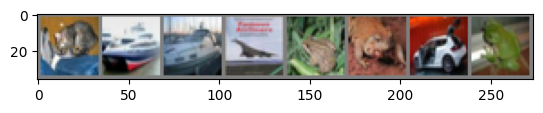

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 
Predicted:    frog  horse frog  frog  frog  frog  horse horse


In [ ]:
# Visualize before training

print("\nPredictions from the UNTRAINED network (random guessing)")

# Get a batch of images from the test loader
dataiter_viz = iter(testloader_cifar)
images_for_viz, labels_for_viz = next(dataiter_viz)

# Show the images
imshow(torchvision.utils.make_grid(images_for_viz[:8]))

# Print the ground truth labels
print('GroundTruth: ', ' '.join(f'{classes[labels_for_viz[j]]:5s}' for j in range(8)))

# Let the untrained model predict
cifar_net.eval() # Put the model in evaluation mode
with torch.no_grad():
    outputs_before = cifar_net(images_for_viz.to(device))
    _, predicted_before = torch.max(outputs_before, 1)

# Print the model's random guesses
print('Predicted:   ', ' '.join(f'{classes[predicted_before[j]]:5s}' for j in range(8)))

In [ ]:
# Train the network
# For demonstration purposes, we'll only train for a few epochs.
epochs_cifar = 5

for epoch in range(epochs_cifar):
    running_loss = 0.0
    for i, data in enumerate(trainloader_cifar, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward -> backward -> optimize
        outputs = cifar_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch   200] loss: 2.304
[Epoch 1, Batch   400] loss: 2.302
[Epoch 1, Batch   600] loss: 2.299
[Epoch 2, Batch   200] loss: 2.285
[Epoch 2, Batch   400] loss: 2.252
[Epoch 2, Batch   600] loss: 2.158
[Epoch 3, Batch   200] loss: 2.007
[Epoch 3, Batch   400] loss: 1.940
[Epoch 3, Batch   600] loss: 1.887
[Epoch 4, Batch   200] loss: 1.762
[Epoch 4, Batch   400] loss: 1.729
[Epoch 4, Batch   600] loss: 1.691
[Epoch 5, Batch   200] loss: 1.625
[Epoch 5, Batch   400] loss: 1.621
[Epoch 5, Batch   600] loss: 1.566
Finished Training



 Predictions from the TRAINED network (after 5 epochs)


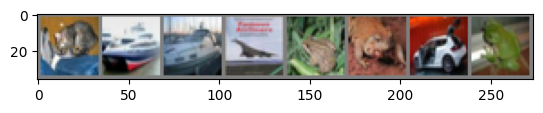

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 
Predicted:    cat   ship  ship  ship  frog  frog  ship  frog 


In [ ]:
# Visualize after Training

print("\n Predictions from the TRAINED network (after 5 epochs)")

# Show the same images again for reference
imshow(torchvision.utils.make_grid(images_for_viz[:8]))

# Print the ground truth labels again
print('GroundTruth: ', ' '.join(f'{classes[labels_for_viz[j]]:5s}' for j in range(8)))

# Let the trained model predict on the same images
cifar_net.eval() # Put the model in evaluation mode
with torch.no_grad():
    outputs_after = cifar_net(images_for_viz.to(device))
    _, predicted_after = torch.max(outputs_after, 1)

# Print the model's new predictions
print('Predicted:   ', ' '.join(f'{classes[predicted_after[j]]:5s}' for j in range(8)))

In [ ]:
# Evaluate the model on the test set
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients
with torch.no_grad():
    for data in testloader_cifar:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = cifar_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# This is just a quick demo. Higher accuracy requires a more advanced architecture and longer training.
print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 42 %


## Summary

So, what are the main things we learned from today's experiments?

**CNNs vs. Fully-Connected Networks**: CNNs are way more efficient for images. Thanks to parameter sharing and local connections, they use fewer parameters to get better results, faster.

**Kernels (Filters)**: These are the heart of a CNN. Through training, they automatically learn to detect basic features like edges, corners, and textures.

**Stacking (Going Deeper)**: Adding more convolutional layers lets the network learn more complex features from simpler ones. In short, going deeper often leads to better performance.

**Pooling Layers**: Max pooling is a simple way to downsample. It helps in two key ways:

> It shrinks the feature maps, which speeds up training and reduces the total number of parameters.

> It pulls out the strongest features, which helps the model become more robust to where things are in an image. This is called translation invariance.

**Adapting to New Data (like CIFAR-10)**: CNNs are super flexible. We saw how easy it was to switch from grayscale MNIST to color CIFAR-10 just by changing the number of input channels in the first layer.

**Regularization (Dropout)**: Overfitting is a huge issue, especially with deep networks. Dropout is a simple but powerful tool to fight overfitting and help our model generalize better to new, unseen data.

